In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [9]:
d90_file = '../results/complexity_utf-16_4243_20_10_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_5252_20_10_bibles_lcm.csv'

# Carregar o arquivo original
original_file1 = '../dataset/bibles_lcm.csv'
original_file2 = '../dataset/bibles_90_lcm.csv'
df_original1 = pd.read_csv(original_file1)
df_original2 = pd.read_csv(original_file2)

# Calcular o tamanho do texto por língua
text_sizes_90_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_90_lcm = text_sizes_90_lcm.rename(columns={'text': 'text_size'})

text_sizes_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_lcm = text_sizes_lcm.rename(columns={'text': 'text_size'})


df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA']
df90 = df90[df90.language != 'KARAJÁ']
# We removed Nambikuára because it has tone annotation
#df90.loc[df90.metric == 'del-chars', 'value'] = - df90.loc[df90.metric == 'del-chars', 'value']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA'] 
dfall = dfall[dfall.language != 'KARAJÁ'] # We removed Nambikuára because it has tone annotation
#dfall.loc[dfall.metric == 'del-chars', 'value'] = - dfall.loc[dfall.metric == 'del-chars', 'value']

df90 = df90.merge(text_sizes_90_lcm, on='language', how='left')
dfall = dfall.merge(text_sizes_lcm, on='language', how='left')

family = pd.read_csv('../dataset/family.csv', index_col=None)

/tmp/ipykernel_14704/2311869795.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, color='white')
/tmp/ipykernel_14704/2311869795.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
/tmp/ipykernel_14704/2311869795.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, color='white')
/tmp/ipykernel_14704/2311869795.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
/tmp/ipykernel_14704/2311869795.py:68: UserWarni

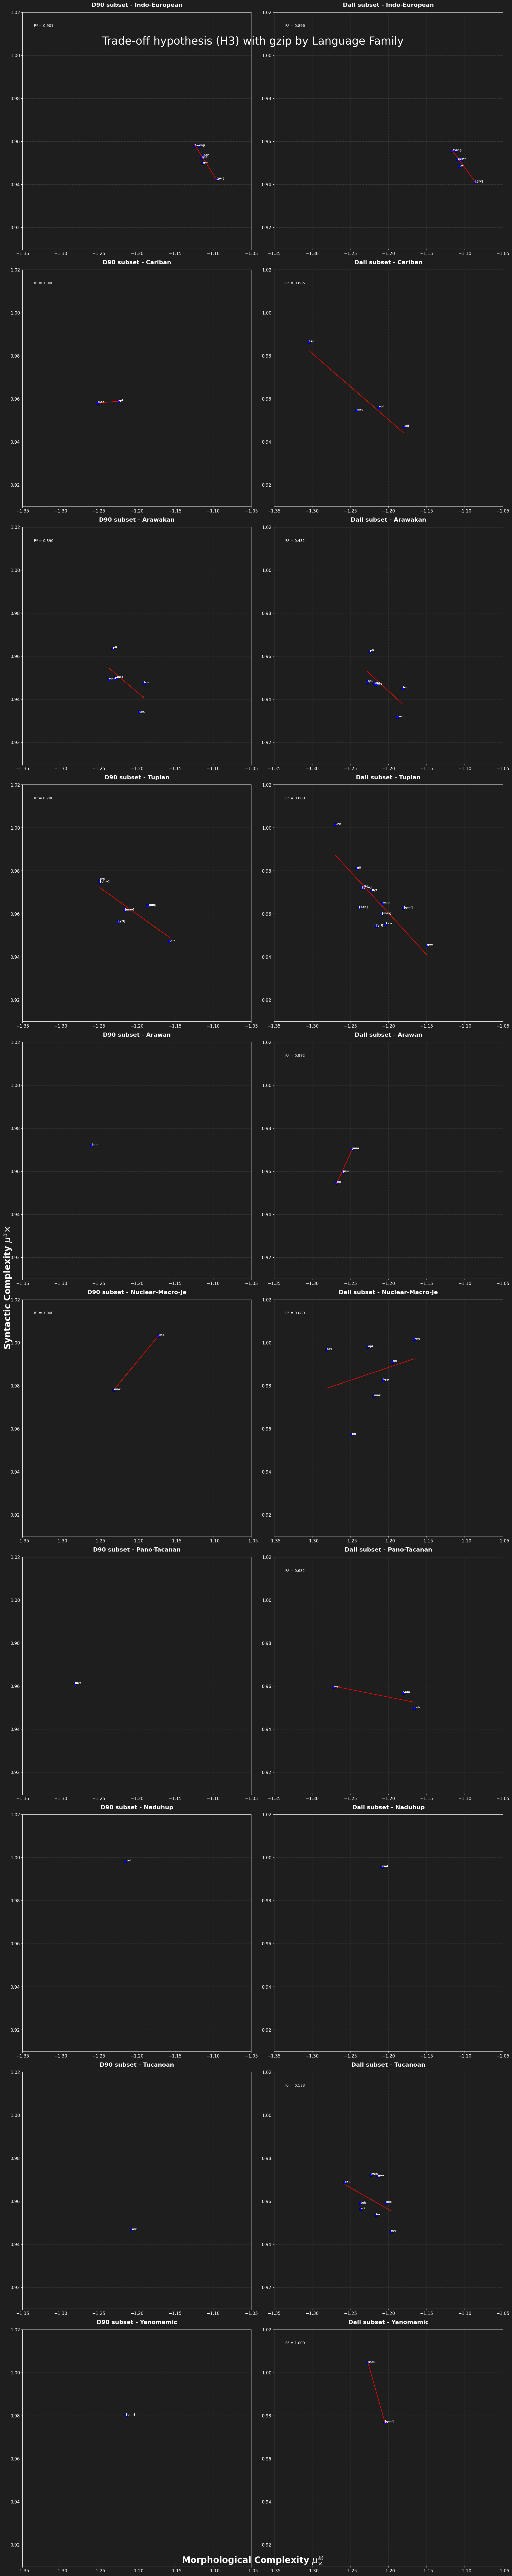

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

def compute(dfi, alg, text_sizes, family):
    df = dfi.copy()
    ag = df.algorithm == alg
    dw = df.metric == 'del-words'
    dc = df.metric == 'del-chars'
    
    x = df[dw & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()
    y = df[dc & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()

    df.loc[dw & ag, 'del-words'] = x
    df.loc[dw & ag, 'del-chars'] = y
    df = df.dropna().drop_duplicates('language').reset_index().drop(columns=['metric', 'index', 'run_id'])
    
    df = df.merge(text_sizes, on='language', how='left')
    df = df.merge(family[['wals', 'family_glottocode']], on='wals', how='left')

    return df

def calculate_regression(x, y):
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    r_squared = r_value**2
    return slope, intercept, r_squared

def plot_regression_by_family(df90, dfall, algo, family, text_sizes_90, text_sizes_all):
    def process_df(df, algo, text_sizes):
        return compute(df, algo, text_sizes, family)

    df90 = process_df(df90, algo, text_sizes_90)
    dfall = process_df(dfall, algo, text_sizes_all)

    unique_families = df90['family_glottocode'].unique()
    n_families = len(unique_families)
    
    fig, axs = plt.subplots(n_families, 2, figsize=(20, 10*n_families), facecolor='#1e1e1e')
    fig.suptitle(f"Trade-off hypothesis (H3) with {algo.lower()} by Language Family", fontsize=30, color='white')
    fig.supylabel(r'Syntactic Complexity $\mu^{\mathbb{S}}{\times}$', weight='bold', fontsize=24, color='white')
    fig.supxlabel(r'Morphological Complexity $\mu^{\mathbb{M}}_{\times}$', weight='bold', fontsize=24, color='white')

    for i, family in enumerate(unique_families):
        for j, (df, title) in enumerate(zip([df90, dfall], ['D90 subset', 'Dall subset'])):
            ax = axs[i, j]
            df_family = df[df['family_glottocode'] == family]
            
            x = df_family['del-chars'].to_numpy()
            y = df_family['del-words'].to_numpy()
            
            ax.set_facecolor('#1e1e1e')
            ax.set_xlim((-1.35, -1.05))
            ax.set_ylim((0.91, 1.02))
            ax.grid(True, linestyle='--', alpha=0.3, color='gray')
            
            ax.scatter(x, y, c='blue', edgecolor='black', linewidth=1, s=70)
            
            if len(x) > 1 and len(y) > 1:
                slope, intercept, r2 = calculate_regression(x, y)
                x_range = np.linspace(x.min(), x.max(), 100)
                ax.plot(x_range, slope * x_range + intercept, 'r-')
                ax.text(0.05, 0.95, f"R² = {r2:.3f}", transform=ax.transAxes, fontsize=10,
                        verticalalignment='top', color='white')
            
            ax.set_title(f"{title} - {family}", fontsize=16, weight='bold', pad=15, color='white')
            ax.tick_params(colors='white')
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, color='white')
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, color='white')
            
            for spine in ax.spines.values():
                spine.set_edgecolor('white')
            
            for xi, yi, li in zip(x, y, df_family['wals']):
                ax.text(xi, yi, li, fontsize=8, weight='bold', color='white')

    plt.tight_layout()
    plt.savefig("../images/h3_regression_by_family.pdf", bbox_inches='tight', facecolor='#1e1e1e')

# Carregar os dados
d90_file = '../results/complexity_utf-16_10_10_1234_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_10_10_1234_bibles_lcm.csv'
original_file1 = '../dataset/bibles_lcm.csv'
original_file2 = '../dataset/bibles_90_lcm.csv'

df_original1 = pd.read_csv(original_file1)
df_original2 = pd.read_csv(original_file2)

text_sizes_90_lcm = df_original2.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_90_lcm = text_sizes_90_lcm.rename(columns={'text': 'text_size'})

text_sizes_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_lcm = text_sizes_lcm.rename(columns={'text': 'text_size'})

df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA']
dfall = dfall[dfall.language != 'KARAJÁ'] 

family = pd.read_csv('../dataset/family.csv', index_col=None)

# Chamar a função para criar o gráfico
plot_regression_by_family(df90, dfall, 'gzip', family, text_sizes_90_lcm, text_sizes_lcm)